# Quality of asymptotic approximation for Wald test statistic for SVD
This notebook contains replication files for the figures relating to the Wald test statistic for inference on singular subspaces.

In [1]:
using Distributions, Statistics, LinearAlgebra, StatsPlots
pgfplotsx()

┌ Warning: backend `PGFPlotsX` is not installed.
└ @ Plots /Users/jerome/.julia/packages/Plots/7R93Y/src/backends.jl:43


Plots.PGFPlotsXBackend()

In [2]:
ms=2
n=5
m = 3
M2 = [[rand(1:ms*n) for i in 1:ms, j in 1:n]; zeros(1,n)]
F = 2
mu = zeros(m)
cov = [ 1 2 4 ; 2 3 3.5; 2 5 7];
c = cov * cov' / 100;
d = MvNormal(mu,c);
mc_reps = 2000;
sample_size = 500;
q = 1;
rand(d,n)

3×5 Matrix{Float64}:
 0.366744  -0.455269  0.356392  0.529832  -0.147808
 0.275678  -0.556087  0.63357   0.664619  -0.0473941
 0.758749  -0.889463  0.77674   1.0335    -0.311534

In [3]:
ms=2
n=5
m = 3
M2 = [[rand(1:ms*n) for i in 1:ms, j in 1:n]; zeros(1,n)]
F = 2
mu = zeros(m)
cov = [ 1 2 4 ; 2 3 3.5; 2 5 7];
c = cov * cov' / 100;
d = MvNormal(mu,c);
mc_reps = 2000;
sample_size = 500;
q = 1;
f = q;

#first dimension of errors is mc_reps and second dimension is sample
errors = [M2 + rand(d,n) for _ in 1:mc_reps, _ in 1:sample_size];
#makes a mc_reps by 1 matrix of matrices
matrix_estimates = mean(errors,dims=(2));

demeaned_matrices = [errors[i,:,:] .- matrix_estimates[i,:,:] for i in 1:mc_reps]

cov_estimates = Array{Float64,3}(undef,mc_reps,m*n,m*n) 
smaller_cov_estimate = Array{Float64}(undef,m,m);
smaller_cov_estimates = Array{Float64,3}(undef,mc_reps,m,m)

for mcrep in 1:mc_reps
    cov_estimate = Array{Float64,2}(undef,m*n,m*n);
    fill!(cov_estimate,0.0);
    for s in 1:sample_size
        cov_estimate += vec(demeaned_matrices[mcrep][s])*vec(demeaned_matrices[mcrep][s])';
    end
    #average across other dimension
    fill!(smaller_cov_estimate,0.0)
    for maus in 1:n
        #1 p+1 2p+1 to p 2p 
        smaller_cov_estimate += cov_estimate[(1+ (maus-1)*m) : (maus*m) , (1+ (maus-1)*m) : (maus*m) ]
    end

    cov_estimates[mcrep,:,:] = cov_estimate / sample_size;
    smaller_cov_estimates[mcrep,:,:] = smaller_cov_estimate / (n*sample_size)
end


Now, we have made errors, find a matrix

In [4]:
F = svd(M2)
Us = F.U[:,1:q];
Usperp = nullspace(Us')
Usperp'Us
Us'Us

1×1 Matrix{Float64}:
 0.9999999999999999

Make a null DGP

In [5]:
F=2;
Fac=svd(M2)
Us = Fac.U[:,1:F];
Σs = Diagonal(Fac.S[1:F])
Vsp = Fac.Vt[1:F,:]
round.(M2 - Us * Σs * Vsp) .== 0
Un = Fac.U[:,(F+1):m]
Σn = Fac.S[F+1:m] |> Diagonal
Vn = Fac.Vt[F+1:m,:]
Df = zeros(F,F);
#singular vector of interest f = 1
u0f_perp = nullspace(Us[:,f]')[:,1]

3-element Vector{Float64}:
 -0.7657805741822209
  0.6431019454216789
  0.0

Check that an estimated SVD works roughly.

In [6]:
svd(matrix_estimates[1])

SVD{Float64, Float64, Matrix{Float64}, Vector{Float64}}
U factor:
3×3 Matrix{Float64}:
 -0.642789     0.766027     0.00506659
 -0.766042    -0.642786    -0.00241629
  0.00140579  -0.00543438   0.999984
singular values:
3-element Vector{Float64}:
 21.18820147387426
  5.217836052137869
  0.027515294933541396
Vt factor:
3×5 Matrix{Float64}:
 -0.16958    -0.223819  -0.452947   -0.567917   -0.627262
 -0.0751255   0.487437  -0.790241    0.0654417   0.357768
  0.70792     0.333384  -0.0779867   0.309759   -0.534482

In [7]:
include("definitions_test_statistics.jl")
waldresult3 = [WaldStatSingleVector(u0f_perp,matrix_estimates[i],smaller_cov_estimates[i,:,:],f,F,sample_size) for i in 1:mc_reps];

Check that we don't need to impose the rank correctly, as specified in Liu and Ma (2007), i.e. it does not matter whether the constraint binds or not in $F \leq \min(n,m)$

In [8]:
include("definitions_test_statistics.jl")
waldresult4 = [WaldStatSingleVector(u0f_perp,matrix_estimates[i],smaller_cov_estimates[i,:,:],f,min(n,m),sample_size) for i in 1:mc_reps];

In [9]:
chsq = Chisq(1);
reference = [rand(chsq) for _ in 1:mc_reps];

## Correctly imposing reduced rank
The underlying perturbation theory builds on the null model that has a reduced rank which we impose during estimation. Assuming such reduced rank produces the following asymptotic approximation.

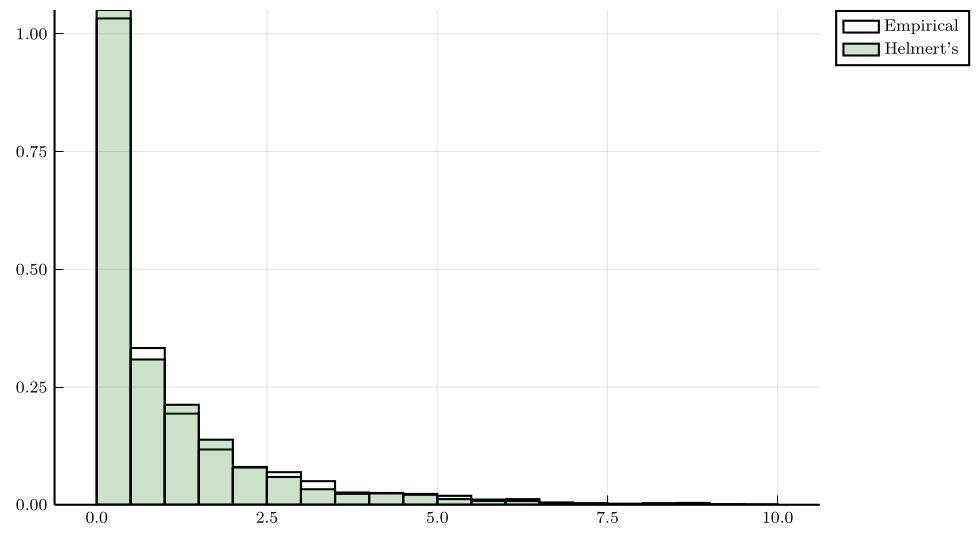

In [10]:
b_range = range(0, 10, length=21)
histogram([waldresult3 reference], label=["Empirical" "Helmert's"],bins=b_range,normalize = :pdf, color=[:red :green],fillalpha=[0.01 0.2])

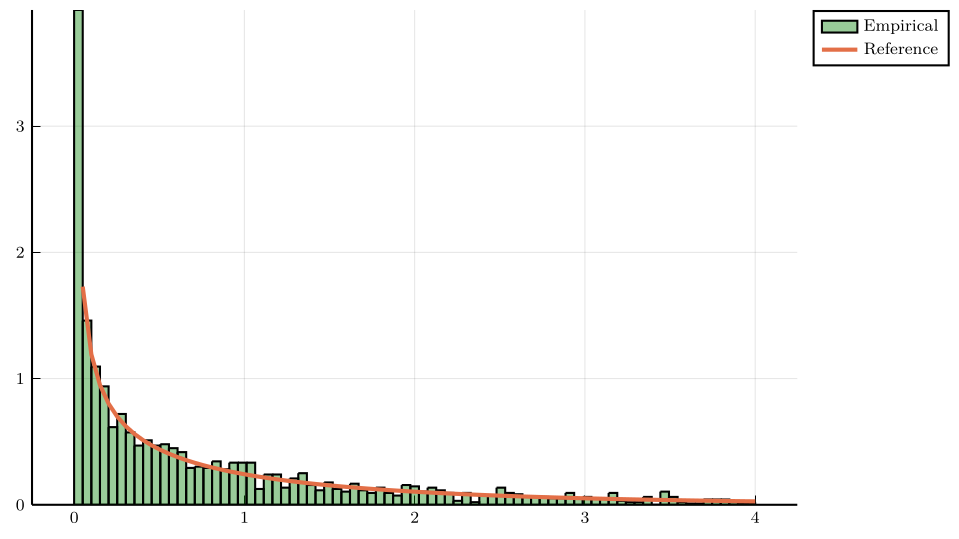

In [11]:
#import Pkg; Pkg.add("LaTeXStrings");
#using LaTeXStrings;
b_range2 = range(0, 4, length=80)
densplot=histogram(waldresult3, label="Empirical",bins=b_range2,normalize = :pdf, color=:green,fillalpha=0.4)
plot!(densplot,b_range2,Chisq(1),label="Reference",lw=2) #label=L"\chi^2_{1}"
densplot

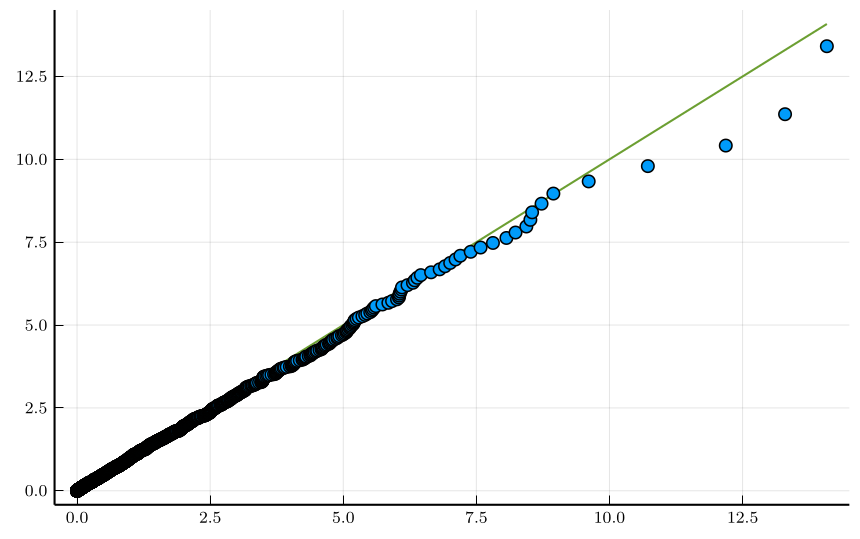

In [12]:
quant_plot = qqplot(waldresult3,Chisq(1))

## Incorrectly imposing full rank
We re-ran the experiment imposing full rank, which, as expected, does not change the underlying distribution.

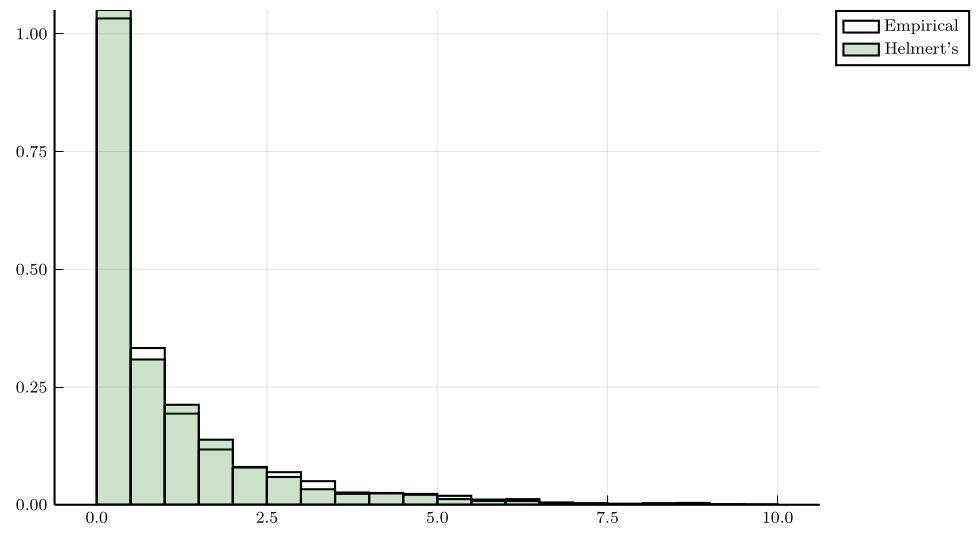

In [13]:
b_range = range(0, 10, length=21)
histogram([waldresult4 reference], label=["Empirical" "Helmert's"],bins=b_range,normalize = :pdf, color=[:red :green],fillalpha=[0.01 0.2])

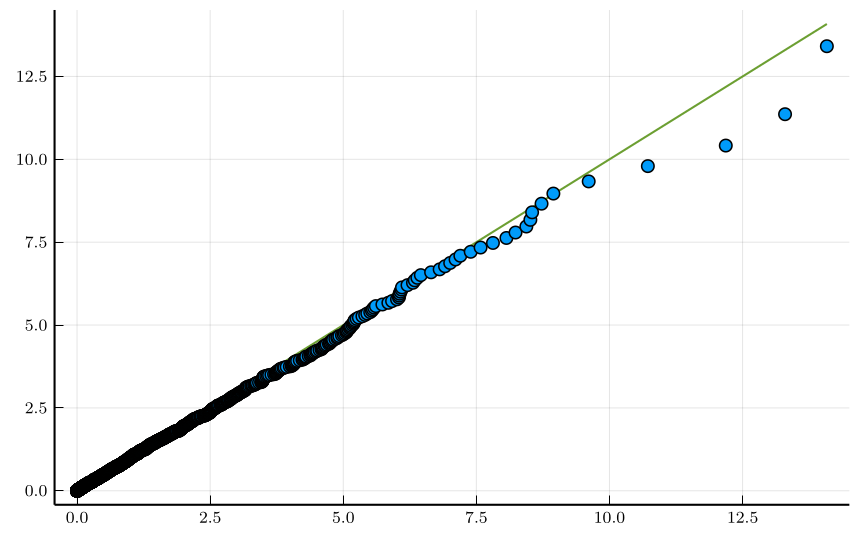

In [14]:
quant_plot_fullrank = qqplot(waldresult4,Chisq(1))

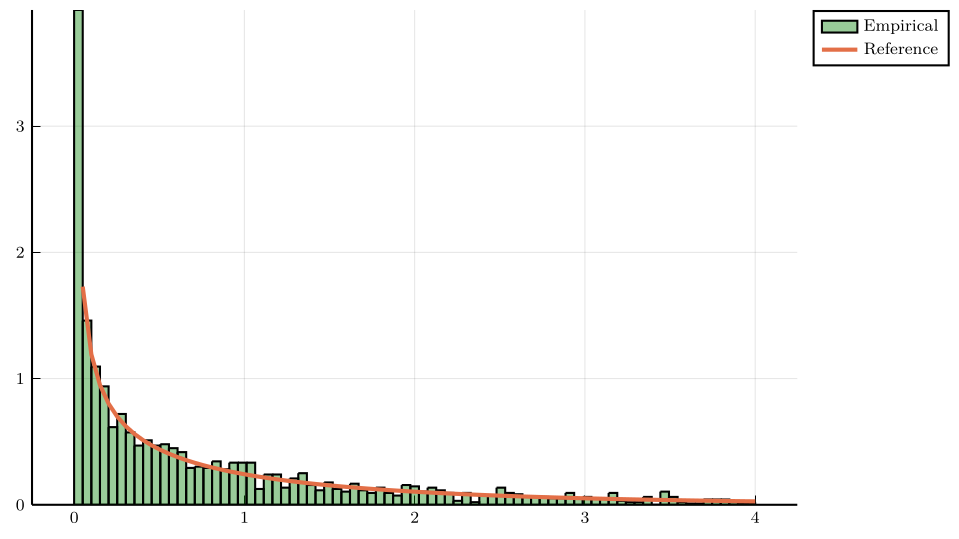

In [15]:
b_range2 = range(0, 4, length=80)
densplot_full_rank=histogram(waldresult4, label="Empirical",bins=b_range2,normalize = :pdf, color=:green,fillalpha=0.4)
plot!(densplot_full_rank,b_range2,Chisq(1),label="Reference",lw=2) #label=L"\chi^2_{1}"
densplot_full_rank

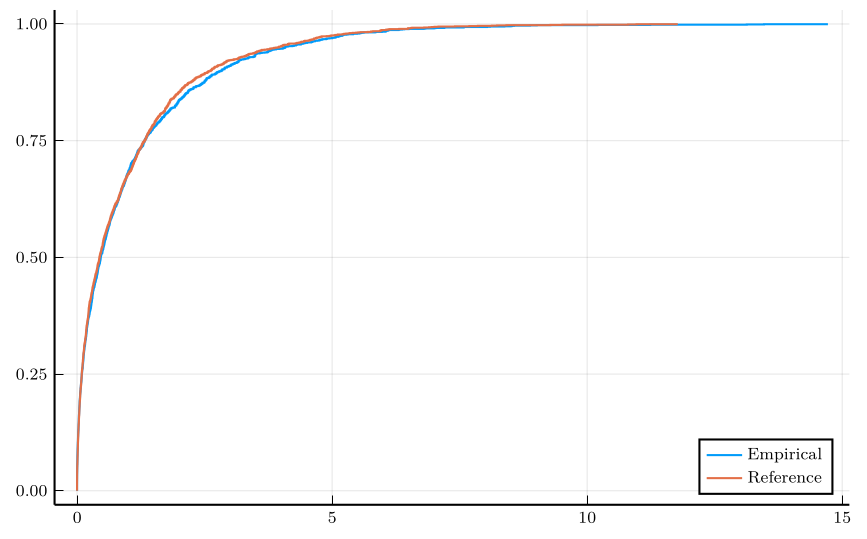

In [16]:
using StatsBase
scatter(ecdf(waldresult3),label="Empirical")
scatter!(ecdf(reference),label="Reference",legend=:bottomright)

In [17]:
savefig("cdfwald-svd.svg")
png(densplot,"density_wald_svd")
savefig(quant_plot,"qqplot2_svd.svg")

## Empirical size
Estimate size using chi squared critical values

In [18]:
rejections = waldresult3 .> 3.841;
mean(rejections)

0.055